<style type="text/css">
.reveal h1 {
    font-size: 2em;
}
</style>

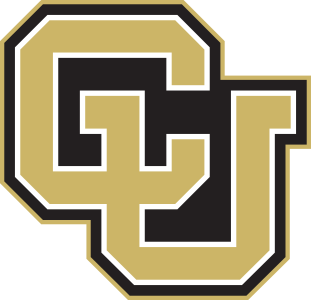

# Lecture 03, hands-on: $k$-means
*(CPBS 7602: Introduction to Big Data in the Biomedical Sciences)*

By __Milton Pividori__<br>Department of Biomedical Informatics<br>University of Colorado Anschutz Medical Campus

# Goals
* Identify the components of an unsupervised learning problem.
* Use sklearn for clustering analysis and familiarize yourself with the API.
* Basic understanding of centroid-based algorithms ($k$-means) and other algorithms.
* Clustering in practice: feature scaling and interpretability.

# Reading Material

Check out different resources and documentation from sklearn.

* [Clustering guide](https://scikit-learn.org/1.5/modules/clustering.html) from sklearn:
  * Introduction to **different clustering methods**.
  * Clustering **performance evaluation**:
    * **When we know** the ground-truth (external metrics):
      * Based on Rand Index, such as ARI.
      * Based on mutual information, such as NMI.
    * **When we don't know** the ground-truth (internal metrics):
      * Silhouette coefficient
      * Calinski-Harabasz Index
      * Davies-Bouldin Index

# Modules

In [21]:
# load modules
import sklearn
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt





# Dataset 1

Load dataset. Feature names have the format "f[NUMBER]". Column "labels", if present, are the true labels/clusters.

In [27]:
# load dataset
data = pd.read_csv(
    "https://www.dropbox.com/scl/fi/8elyky9mtq9nser82xk05/dataset01.tsv?rlkey=wlue2ejkkyen8ghdxah6yqso2&st=n9x9muq9&dl=1",
    sep="\t",
)

## Question 1

How many objects ($n$) and features ($d$) are in this dataset?

In [28]:
print(data.describe)
data.shape

<bound method NDFrame.describe of           f1        f2        f3        f4        f5        f6        f7  \
0  -0.330916 -0.411204  1.806458  3.881925  1.703582  0.184864  1.565088   
1   0.005613 -0.003614  0.177467  2.373105  1.515870  2.381005  2.565380   
2  -0.050342 -0.338685  2.532612  0.597579  2.660178  2.668388  0.638148   
3   0.100639  0.693432  2.062112  2.031477  2.613821  3.768640  2.383001   
4  -0.160311 -0.576029  2.931509  1.552599  3.799989  1.763680  2.892516   
..       ...       ...       ...       ...       ...       ...       ...   
95  3.052529 -4.626295  2.223467  1.885274  1.103618  0.512939  1.362580   
96  2.868913 -5.147150  1.158416  3.727235  2.932395  3.475475  1.784163   
97  3.843659 -3.116299  1.598951  1.263434  2.587882  1.098213  1.172591   
98  5.574960 -2.224370  3.575653  2.486362  2.195039  0.361405  1.706062   
99  4.142328 -3.338948  1.524521  1.507534  2.230670  0.101506  0.496185   

          f8        f9       f10       f11       f12 

(100, 13)

_Answer_: There are 100 observations (_n_) and 12 features (_d_)

## Question 2

Does this dataset have the ground-truth or "true" labels/clusters?
How many clusters are present in this ground-truth, and how many objects are in each "true" cluster?
Which metrics can we use to measure performance?

In [30]:
data_labels = data.pop("labels")

data_labels.value_counts()

labels
1    25
2    25
3    25
4    25
Name: count, dtype: int64

_Answer_: There are labels (1-4) for the dataset in the column labels. 25 values for each label. External and internal metrics. 

## Question 3

We want to understand whether there is some structure in the data among objects.
Perform a cluster analysis using $K$-Means to answer the following questions:
1. Are there stable clusters in the data?
2. What are the optimal parameters of a $K$-Means model that maximize the agreement with the true labels? Use at least two different metrics to compare the true labels with the $K$-Means labels.
3. Do clustering solutions in 1. and 2. coincide? Why or why not?

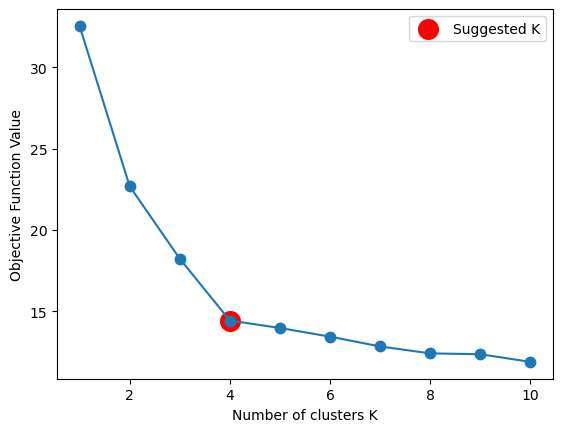

In [37]:
from sklearn import cluster
model = cluster.KMeans(n_clusters=4, n_init="auto")

from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_rand_score as ari
np.random.seed(0)

# get data into numpy array 
X = data.to_numpy()

# elbow method
Ks, objs = range(1, 11), []
for k in Ks:
    model = cluster.KMeans(n_clusters=k, n_init="auto")
    model.fit(X)
    objs.append(-model.score(X) / X.shape[0])

plt.plot(Ks, objs, ".-", markersize=15)
plt.scatter([4], [objs[3]], s=200, color="red", label="Suggested K")
plt.xlabel("Number of clusters K")
plt.ylabel("Objective Function Value")
plt.legend()

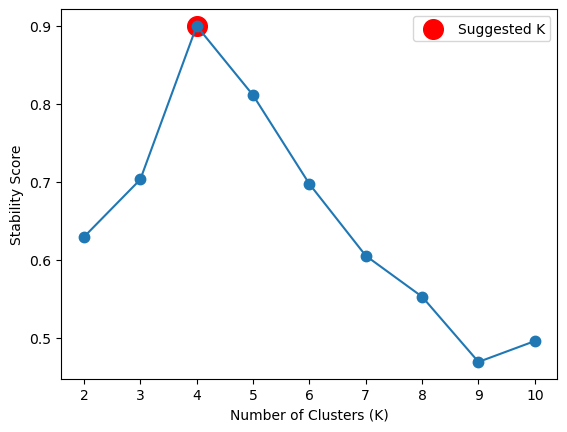

In [40]:
# consensus method
Ks = range(2, 11)
n_reps = 10
cluster_labels = []
pairwise_ari = []
centroid_positions = {}
stability_scores = []

for k in Ks:
    labels = []
    centroids = []

    for _ in range(n_reps):
        model = cluster.KMeans(n_clusters=k, n_init="auto")
        labels.append(model.fit_predict(X))
        centroids.append(model.cluster_centers_)

    cluster_labels.append(labels)
    centroid_positions[k] = centroids

    # Compute pairwise adjusted Rand index (ARI) for stability
    ari_distances = pdist(labels, metric=ari)
    pairwise_ari.append(ari_distances)
    stability_scores.append(ari_distances.mean())
plt.plot(Ks, stability_scores, marker=".", linestyle="-", markersize=15)
plt.scatter(
    [4],
    [stability_scores[2]],
    s=200,
    color="red",
    label="Suggested K",
)
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Stability Score")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import normalized_mutual_info_score as nmi
perf_nmi = {}
perf_ari = {}
for k in Ks: 
    model = cluster.KMeans(n_clusters=k, n_init="auto")
    part = model.fit_predict(X)
    perf_ari[k] = ari(part, data_labels)
    perf_nmi[k] = nmi(part, data_labels)

_Answer_: 4 is the most stable solution across both the elbow and index. 

## Question 4

Use at least two internal metrics to measure the quality of the clustering solutions.

1. Do they match with the agreement with the true labels? Why?
2. Do they match among them?

_Answer_: add answer

## Question 5

Explore the different features of the dataset and find the top 2 ones that are most helpful to capture the true labels in the data. Answer the following questions:

1. What are the most important features that the algorithm used to accurately cluster the data? Are some features more important than others?
1. How did you explore the set of features to pick the best ones?
1. Create a 2-dimensional plot using the two top features you found. Include the true labels and centroids learned by $K$-Means using the $K$ with the most accurate solution.
1. Related to the second question: think about some approaches that could be used to automatically learn the most important features that are driving clustering results.

_Answer_: add answer

## Question 6

Let's assume that our dataset's objects are people and its features include measurements such as height (in meters, with values such as `1.55` or `1.95`) and year of birth (such as `1945` or `2001`). Clearly, these two features have different scales. Let's simulate that in our dataset:

In [21]:
# let's see what are the stats across features in the original data
data.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.426425,1.222585,2.122137,2.034657,2.047784,1.901838,1.814660,1.972853,2.160616,1.802824,1.945195,2.067451
std,2.762913,3.476864,1.169307,1.143062,1.063029,1.185629,1.080893,1.161838,1.157607,1.147469,1.174753,1.174859
min,-4.539012,-5.190981,0.073070,0.033522,0.070147,0.012054,0.048035,0.049635,0.014697,0.088058,0.023665,0.017672
25%,-0.487561,-1.019238,1.166957,1.018976,1.270292,0.853160,0.789670,0.892831,1.247181,0.764301,0.825872,1.193729
50%,1.183115,0.806465,2.049049,2.021329,2.055746,1.907358,1.897732,2.149544,2.183210,1.701763,1.962398,2.139220
75%,3.929524,4.200504,3.139445,3.056537,2.837758,2.781726,2.641203,2.915272,3.147419,2.835454,2.944727,3.221551
max,6.508632,6.873952,3.968635,3.980859,3.954391,3.979962,3.825164,3.981973,3.979669,3.899856,3.958024,3.975148


In [22]:
data_scaled = data.copy()

In [23]:
from sklearn.preprocessing import minmax_scale

In [24]:
# f6 will be height
data_scaled["f6"] = minmax_scale(data["f6"], feature_range=(1.2, 2.05))

# and f7 will be year of birth
data_scaled["f7"] = np.ceil(minmax_scale(data["f7"], feature_range=(1945, 2001)))

In [25]:
# let's verify the stats/ranges of our new features
data_scaled.describe()

,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1.426425,1.222585,2.122137,2.034657,2.047784,1.604827,1971.710000,1.972853,2.160616,1.802824,1.945195,2.067451
std,2.762913,3.476864,1.169307,1.143062,1.063029,0.253984,16.010284,1.161838,1.157607,1.147469,1.174753,1.174859
min,-4.539012,-5.190981,0.073070,0.033522,0.070147,1.200000,1945.000000,0.049635,0.014697,0.088058,0.023665,0.017672
25%,-0.487561,-1.019238,1.166957,1.018976,1.270292,1.380180,1956.750000,0.892831,1.247181,0.764301,0.825872,1.193729
50%,1.183115,0.806465,2.049049,2.021329,2.055746,1.606009,1973.000000,2.149544,2.183210,1.701763,1.962398,2.139220
75%,3.929524,4.200504,3.139445,3.056537,2.837758,1.793315,1984.000000,2.915272,3.147419,2.835454,2.944727,3.221551
max,6.508632,6.873952,3.968635,3.980859,3.954391,2.050000,2001.000000,3.981973,3.979669,3.899856,3.958024,3.975148


It can be seen that the mean, standard deviation, minimum, and maximum values are very different now when we compare the features.

1. How does our clustering approach perform in this new dataset?
2. Why is this happening? How can we fix it? *Tip:* take a look at the [preprocessing functions in sklearn](https://scikit-learn.org/1.5/modules/preprocessing.html). Try the [StandardScaler](https://scikit-learn.org/1.5/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

_Answer_: add answer

# Dataset 2

In [41]:
# load dataset
data = pd.read_csv(
    "https://www.dropbox.com/scl/fi/mfllucl6fu2awou5hg90p/dataset02.tsv?rlkey=vcbr61pr5159qo4ynh49vpq4o&st=gec1pm6r&dl=1",
    sep="\t",
)

## Previous Questions 1-5

Answer the same questions for Dataset 1.

### Question 1

_Answer_: add answer

### Question 2

_Answer_: add answer

### Question 3

_Answer_: add answer

### Question 4

_Answer_: add answer

### Question 5

_Answer_: add answer

# Dataset 3

In [51]:
# load dataset
data = pd.read_csv(
    "https://www.dropbox.com/scl/fi/2wtandc0jofhw0i4ivh1v/dataset03.tsv?rlkey=jtv6zbpaw0c5v70kd73uj2ccs&st=mkv2zlzs&dl=1",
    sep="\t",
)

## Previous Questions 1-5

Answer the same questions for Dataset 2.

**In addition**, answer Question 7 below for this dataset.

### Question 1

_Answer_: add answer

### Question 2

_Answer_: add answer

### Question 3

_Answer_: add answer

### Question 4

_Answer_: add answer

### Question 5

_Answer_: add answer

## Question 7

As you probably guessed after answering Question 5 and making the plot, this dataset has a weird structure: it has two concentric rings.
It was generated with function [`make_circles`](https://scikit-learn.org/dev/modules/generated/sklearn.datasets.make_circles.html) from sklearn.
These complex datasets are used to test different clustering and classification algorithms with different degrees of difficulty.

So here you have the **first question**:
1. $K$-Means cannot capture this structure. Why not?

Now, let's try to answer Questions 3-5 but using different clustering algorithms and explore different parameters.
Some suggestions are:
* [Spectral Clustering](https://scikit-learn.org/1.5/modules/clustering.html#spectral-clustering):
  * It computes a low-dimensional embedding of the input data where the complex data structures (such as the rings) are more apparent. Then it applies $K$-Means on this embedding.
  * A suggestion on how to run it:

    ```python
        cluster.SpectralClustering(
            n_clusters=k, affinity="nearest_neighbors", n_init=1
        )
    ```

    You can try different parameters such as `affinity` or `gamma`.
* [DBSCAN](https://scikit-learn.org/1.5/modules/clustering.html#dbscan):
  * This algorithm is very different from $K$-Means. It is not centroid-based, but density-based. Some analyses, such as Consensus Index, are not directly applicable here.
  * The most important parameter is `eps`: make sure you use values around `0.30` for this dataset. One way to generate values in an interval is to use `np.linspace(0.20, 0.50, 100)`
  * A suggestion on how to run it:

    ```python
        model = cluster.DBSCAN(eps=k)
    ```

* [Hierarchical clustering](https://scikit-learn.org/1.5/modules/clustering.html#hierarchical-clustering):
  * This is a classic algorithm, very popular.
  * In addition to returning a single, flat partition, hierarchical clustering can produce a hierarchy of partitions, where clusters are subsequently divided into smaller ones. This hierarchical structure might be very useful in particular problems where we expect this data structure.
  * The main parameter, in addition to the number of clusters, is the `linkage` criteria that determines how to merge clusters.

Then also answer these **other questions**:

2. Were you successful with a different clustering algorithm? Which one?
3. Why did the new algorithm work?

_Answer_: add answer

### Spectral Clustering

#### Question 3

#### Question 4

#### Question 5

### DBSCAN

#### Question 3

#### Question 4

#### Question 5

### Hierarchical Clustering

#### Question 3

#### Question 4

#### Question 5